In [94]:
!wget https://dataworks.indianapolis.iu.edu/bitstream/handle/11243/41/data.zip
!unzip data.zip
!rm data.zip

In [95]:
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Dataset import

In [96]:
class ImageDNADataset(Dataset):
    def __init__(self, train=True):
        splits_mat = scipy.io.loadmat("data/INSECTS/splits.mat")
        train_loc = splits_mat["train_loc"]-1
        trainval_loc = splits_mat["trainval_loc"]-1
        test_seen_loc = splits_mat["test_seen_loc"]-1
        test_unseen_loc = splits_mat["test_unseen_loc"]-1
        val_seen_loc = splits_mat["val_seen_loc"]-1
        val_unseen_loc = splits_mat["val_unseen_loc"]-1

        assert len(trainval_loc[0] == 19420)
        assert len(test_seen_loc[0] == 4965)
        assert len(test_unseen_loc[0] == 8463)

        indeces = (
            trainval_loc
            if train
            else np.concatenate((test_seen_loc, test_unseen_loc), axis=1)
        )
        # indeces.shape is (1, |indeces|), so we extract the whole list using [0]
        indeces = indeces[0]

        data_mat = scipy.io.loadmat("data/INSECTS/data.mat")
        self.embeddings_img = torch.from_numpy(
            data_mat["embeddings_img"][indeces]
        ).float()
        self.embeddings_dna = torch.from_numpy(
            data_mat["embeddings_dna"][indeces]
        ).float()

        # Remap train labels in [0, 796]
        train_labels = data_mat["labels"][trainval_loc][0]
        train_labels_mapping = {label: i for i, label in enumerate(np.unique(train_labels))}
        train_labels_remapped = np.array([train_labels_mapping[label.item()] for label in train_labels])

        # Remap test labels in [797, 1039]
        test_unseen_labels = data_mat["labels"][test_unseen_loc][0]
        test_unseen_labels_mapping = {label: i + 797 for i, label in enumerate(np.unique(test_unseen_labels))}
        test_unseen_labels_remapped = np.array([test_unseen_labels_mapping[label.item()] for label in test_unseen_labels])

        assert np.intersect1d(train_labels, test_unseen_labels).size == 0

        # Union of the two mappings, allows to full remap all the labels
        labels_mapping = train_labels_mapping | test_unseen_labels_mapping
        assert len(labels_mapping) == 1040

        labels = data_mat["labels"][indeces]  # Consider only train/test labels
        remapped_labels = np.array([labels_mapping[label.item()] for label in labels])
        self.remapped_labels = torch.from_numpy(remapped_labels).long()
        self.labels = torch.from_numpy(labels).long()

        if train:
            assert len(torch.unique(self.remapped_labels)) == 797
        else:
            assert len(torch.unique(self.remapped_labels)) == 1013

        # data_mat['G'] returns a ndarray of type uint16, therefore we convert into int16 before invoking from_numpy
        self.G = torch.from_numpy(data_mat["G"].astype(np.int16)).long()
        self.genera = torch.empty(self.labels.shape).long()
        for i in range(indeces.size):
            self.genera[i][0] = self.G[self.labels[i][0] - 1][0] - 1041

        if train:
            assert len(self.genera) == 19420
        else:
            assert len(self.genera) == 13428

        if (not train):
            # Compute genera of unseen species
            unseen_species_genera = []
            for i in test_unseen_loc[0]:
                unseen_species_genera.append(data_mat["G"][data_mat["labels"][i][0] - 1][0] - 1041)

            self.unseen_species_genera = np.array(unseen_species_genera)
            assert len(np.unique(self.unseen_species_genera)) == 134

            # Compute unseen species
            seen_species = []
            for i in test_seen_loc[0]:
                seen_species.append(labels_mapping[data_mat["labels"][i].item()])
            self.seen_species = np.array(seen_species)
            assert len(np.unique(self.seen_species)) == 770

        self.species = data_mat["species"][indeces]
        self.ids = data_mat["ids"][indeces]

    def __len__(self):
        return len(self.embeddings_dna)

    def __getitem__(self, idx):
        embedding_img = self.embeddings_img[idx]
        embedding_dna = self.embeddings_dna[idx]
        embedding = torch.cat(
            (self.embeddings_img[idx], self.embeddings_dna[idx])
        ).view(1, 1, -1)
        label = self.remapped_labels[idx].item()
        genera = self.genera[idx].item()

        return embedding_img.view(1, -1), embedding_dna.view(1, -1), label, genera

# Model definition

In [97]:
class AttentionNet(nn.Module):
        def __init__(self):
                super(AttentionNet, self).__init__()

                self.img_fc1 = nn.Linear(2048, 1024)
                self.img_fc2 = nn.Linear(1024, 500)
                self.cross_img_dna_attention_1 = CrossImageDNAAttention(20, 80, 4)

                self.fc_species_1 = nn.Linear(1000, 1000)
                self.fc_species_2 = nn.Linear(1000, 797)

                self.fc_genera_1 = nn.Linear(1000, 1000)
                self.fc_genera_2 = nn.Linear(1000, 368)

                self.dropout = nn.Dropout(0.5)


        def forward(self, x_img, x_dna):
                x_img = F.relu(self.img_fc1(x_img))
                x_img = F.relu(self.img_fc2(x_img))

                x_img = torch.reshape(x_img, (-1, 25, 20))
                x_dna = torch.reshape(x_dna, (-1, 25, 20))

                x_img, x_dna = self.cross_img_dna_attention_1(x_img, x_dna)

                x = torch.cat((x_img, x_dna), axis=2)
                x = torch.reshape(x, (-1, 1000))

                x_species = x.clone()
                x_genera = x.clone()

                x_species = self.dropout(F.relu(self.fc_species_1(x_species)))
                x_species = self.fc_species_2(x_species)

                x_genera = self.dropout(F.relu(self.fc_genera_1(x_genera)))
                x_genera = self.fc_genera_2(x_genera)

                return x_species, x_genera
        


class CrossImageDNAAttention(nn.Module):
        def __init__(self, embed_dim, linear_dim, num_heads):
                super(CrossImageDNAAttention, self).__init__()
                self.multi_head_img_1 = nn.MultiheadAttention(embed_dim, num_heads)
                self.multi_head_dna_1 = nn.MultiheadAttention(embed_dim, num_heads)
                
                self.norm_img_1 = nn.LayerNorm(embed_dim)
                self.norm_dna_1 = nn.LayerNorm(embed_dim)

                self.linear_img_1 = nn.Linear(embed_dim, linear_dim)
                self.dropout_img = nn.Dropout(0.5)
                self.linear_img_2 = nn.Linear(linear_dim, embed_dim)

                self.linear_dna_1 = nn.Linear(embed_dim, linear_dim)
                self.dropout_dna = nn.Dropout(0.5)
                self.linear_dna_2 = nn.Linear(linear_dim, embed_dim)


        def forward(self, x_img, x_dna):
                identity = x_img
                x_img, _ = self.multi_head_img_1(x_img, x_dna, x_dna)
                x_img = self.norm_img_1(x_img + identity)
                x_img = self.feed_forward_img(x_img)

                identity = x_dna
                x_dna, _ = self.multi_head_dna_1(x_dna, x_img, x_img)
                x_dna = self.norm_dna_1(x_dna + identity)
                x_dna = self.feed_forward_dna(x_dna)

                return x_img, x_dna
        
        def feed_forward_img(self, x_img):
                return self.linear_img_2(self.dropout_img(F.relu(self.linear_img_1(x_img))))
        
        def feed_forward_dna(self, x_dna):
                return self.linear_dna_2(self.dropout_dna(F.relu(self.linear_dna_1(x_dna))))

        

model = AttentionNet()
model.to(device)

AttentionNet(
  (img_fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (img_fc2): Linear(in_features=1024, out_features=500, bias=True)
  (cross_img_dna_attention_1): CrossImageDNAAttention(
    (multi_head_img_1): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=20, out_features=20, bias=True)
    )
    (multi_head_dna_1): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=20, out_features=20, bias=True)
    )
    (norm_img_1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    (norm_dna_1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    (linear_img_1): Linear(in_features=20, out_features=80, bias=True)
    (dropout_img): Dropout(p=0.5, inplace=False)
    (linear_img_2): Linear(in_features=80, out_features=20, bias=True)
    (linear_dna_1): Linear(in_features=20, out_features=80, bias=True)
    (dropout_dna): Dropout(p=0.5, inplace=False)
    (linear_dna_2): Linear(in_features=80, out_features

# Creating datasets and dataloaders

In [98]:

training_set = ImageDNADataset(train=True)
test_set = ImageDNADataset(train=False)

batch_size = 32
training_loader = torch.utils.data.DataLoader(
    training_set, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False
)

Print datasets statistics.

In [99]:
print(f"Training set has {len(training_set)} instances.")
print(f"Test set has {len(test_set)} instances.")

inputs_img, inputs_dna, labels, genera = next(iter(training_loader))
print(f"Training input batch: {inputs_img.shape}, {inputs_dna.shape}")
print(f"Training label batch: {labels.shape}")
print(f"Training genera batch: {genera.shape}")

Training set has 19420 instances.
Test set has 13428 instances.
Training input batch: torch.Size([32, 1, 2048]), torch.Size([32, 1, 500])
Training label batch: torch.Size([32])
Training genera batch: torch.Size([32])


# Training

In [100]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs = 15

Training starts with the predefined number of epochs.

In [101]:
for epoch in range(epochs):

    running_labels_loss = 0.0
    running_genera_loss = 0.0

    for i, data in enumerate(training_loader, 0):
        inputs_img, inputs_dna, labels, genera = data
        inputs_img, inputs_dna, labels, genera = inputs_img.to(device), inputs_dna.to(device), labels.to(device), genera.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        labels_outputs, genera_outputs = model(inputs_img, inputs_dna)
        labels_loss = criterion(labels_outputs, labels)
        genera_loss = criterion(genera_outputs, genera)
        total_loss = labels_loss + genera_loss
        total_loss.backward()
        optimizer.step()

        # print statistics
        running_labels_loss += labels_loss.item()
        running_genera_loss += genera_loss.item()
        print_step = 500
        if i % print_step == print_step - 1:
            print(f"[{epoch + 1}, {i + 1:5d}] labels loss: {running_labels_loss / print_step:.3f}")
            print(f"[{epoch + 1}, {i + 1:5d}] genera loss: {running_genera_loss / print_step:.3f}")
            running_labels_loss = 0.0
            running_genera_loss = 0.0

print("Finished Training")

[1,   500] labels loss: 6.150
[1,   500] genera loss: 4.835
[2,   500] labels loss: 4.283
[2,   500] genera loss: 2.679
[3,   500] labels loss: 1.555
[3,   500] genera loss: 0.894
[4,   500] labels loss: 0.270
[4,   500] genera loss: 0.188
[5,   500] labels loss: 0.085
[5,   500] genera loss: 0.068
[6,   500] labels loss: 0.046
[6,   500] genera loss: 0.046
[7,   500] labels loss: 0.031
[7,   500] genera loss: 0.026
[8,   500] labels loss: 0.021
[8,   500] genera loss: 0.020
[9,   500] labels loss: 0.018
[9,   500] genera loss: 0.017
[10,   500] labels loss: 0.015
[10,   500] genera loss: 0.013
[11,   500] labels loss: 0.011
[11,   500] genera loss: 0.013
[12,   500] labels loss: 0.011
[12,   500] genera loss: 0.010
[13,   500] labels loss: 0.008
[13,   500] genera loss: 0.009
[14,   500] labels loss: 0.008
[14,   500] genera loss: 0.008
[15,   500] labels loss: 0.007
[15,   500] genera loss: 0.007
Finished Training


# Testing

-------------------------------------------------------------------------------
threshold: 0.9146912192286945
Test described species accuracy: 0.974972873446899
Test undescribed species accuracy: 0.5601220464887104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
threshold: 0.9171855097409386
Test described species accuracy: 0.974900723374749
Test undescribed species accuracy: 0.5609236769436317
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
threshold: 0.9196596149822108
Test described species accuracy: 0.9748466108206365
Test undescribed species accuracy: 0.5621754159612435
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
threshold: 0.9221139120408348
Test

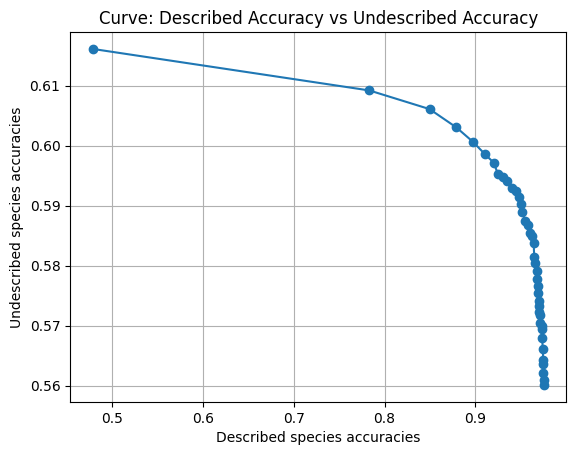

In [102]:
model.eval()

correct_genera = 0
total_genera = 0
correct_labels = 0
total_labels = 0

# Initialize lists to store accuracies
test_described_species_accuracies = []
test_undescribed_species_accuracies = []

# Define the range of thresholds to test
thresholds = np.linspace(0.7, 0.999, 40)**0.25

with torch.no_grad():
    for threshold in thresholds:
        correct_predictions_per_labels = defaultdict(int)
        total_samples_per_labels = defaultdict(int)
        correct_predictions_per_genera = defaultdict(int)
        total_samples_per_genera = defaultdict(int)

        correct_labels = 0
        total_labels = 0
        correct_genera = 0
        total_genera = 0

        for data in test_loader:
            inputs_img, inputs_dna, labels, genera = data
            inputs_img, inputs_dna, labels, genera = inputs_img.to(device), inputs_dna.to(device), labels.to(device), genera.to(device)

            labels_outputs, genera_outputs = model(inputs_img, inputs_dna)

            labels_outputs = nn.Softmax(dim=1)(labels_outputs)
            genera_outputs = nn.Softmax(dim=1)(genera_outputs)

            predicted_labels_values, predicted_labels = torch.topk(labels_outputs.data, k=2, dim=1)
            _, predicted_genera = torch.max(genera_outputs.data, 1)

            differences = predicted_labels_values[:, 0] - predicted_labels_values[:, 1]
            genera_mask = differences <= threshold
            labels_mask = ~genera_mask

            # Update relative frequencies
            for idx in range(len(genera)):
                total_samples_per_labels[labels[idx].item()] += 1

                if labels_mask[idx] and predicted_labels[idx, 0] == labels[idx]:
                    correct_predictions_per_labels[labels[idx].item()] += 1

                # if the sample is of one undescribed species
                if labels[idx].item() not in np.unique(test_set.seen_species):
                    assert genera[idx].item() in np.unique(test_set.unseen_species_genera)
                    total_samples_per_genera[genera[idx].item()] += 1

                    if genera_mask[idx] and predicted_genera[idx] == genera[idx]:
                        correct_predictions_per_genera[genera[idx].item()] += 1


        accuracy_per_label = {label: (correct_predictions_per_labels[label] / total_samples_per_labels[label]) if total_samples_per_labels[label] > 0 else 0 for label in total_samples_per_labels}
        accuracy_per_genera = {genera: (correct_predictions_per_genera[genera] / total_samples_per_genera[genera]) if total_samples_per_genera[genera] > 0 else 0 for genera in total_samples_per_genera}

        test_described_species_accuracy = 0
        for label in np.unique(test_set.seen_species):
            test_described_species_accuracy += accuracy_per_label[label]

        test_undescribed_species_accuracy = 0
        for genera in np.unique(test_set.unseen_species_genera):
            test_undescribed_species_accuracy += accuracy_per_genera[genera]

        print("-------------------------------------------------------------------------------")
        print(f"threshold: {threshold}")
        print(f"Test described species accuracy: {test_described_species_accuracy / 770}")
        print(f"Test undescribed species accuracy: {test_undescribed_species_accuracy / 134}")
        print("-------------------------------------------------------------------------------")

        test_described_species_accuracies.append(test_described_species_accuracy / 770)
        test_undescribed_species_accuracies.append(test_undescribed_species_accuracy / 134)

# Plotting the curve
plt.plot(test_described_species_accuracies, test_undescribed_species_accuracies, marker='o')
plt.xlabel('Described species accuracies')
plt.ylabel('Undescribed species accuracies')
plt.title('Curve: Described Accuracy vs Undescribed Accuracy')
plt.grid(True)
plt.show()